# Preprocessing

To extract measure (correlation coefficient, distance, mutual information and variation of information) pairwise matrices. 

Before running this, run `matlab/preprocess_matfiles.m` first. This normalizes raw fluorescence data to $dF/F_0$ (median smoothing, then performed $(F-F_0)/F_0$ where $F_0$ is a certain percentile of the raw data, then with additional smoothing)

## Initialization

In [1]:
import os, glob, time, pickle
import numpy as np 
from scipy.io import loadmat
from scipy.stats import entropy

In [2]:
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib import rcParams, font_manager
from matplotlib.collections import PatchCollection
from matplotlib.patches import Polygon, RegularPolygon
import seaborn as sns

rcParams.update(mpl.rcParamsDefault)
plt.style.use('default')

# use one of the available styles 
plt.style.use('seaborn-notebook')

# further customization
rcParams['font.family'] = 'FreeSans'
rcParams['font.size'] = 20

rcParams['axes.titlesize'] = 17
rcParams['axes.labelsize'] = 17
rcParams['legend.fontsize'] = 16
rcParams['xtick.labelsize'] = 16
rcParams['ytick.labelsize'] = 16
rcParams['axes.linewidth'] = 1

rcParams['mathtext.fontset'] = 'cm' 
rcParams['mathtext.rm'] = 'serif'

%matplotlib inline

## Load file

In [3]:
preproc_path = 'data/preprocessed/' 
preproc_file = 'purkpop-dFF0.mat'
select_trial_ids = range(65,190) # select trials 065-189

# Load file
preproc_dFF0 = loadmat(preproc_path + preproc_file)
dFF0 = preproc_dFF0['dF_F0']
trial_ids = preproc_dFF0['trial_ids']
data_info = preproc_dFF0['info']

# Select trials 
select_inds = np.where(trial_ids == select_trial_ids)[0] 
dFF0 = [x[0] for x in dFF0[select_inds]]
trial_ids = trial_ids[select_inds]
data_info = {k:float(x[0][0]) if isinstance(x[0], np.ndarray) and len(x) == 1 else x[0] 
             for (k,x) in zip(list(data_info.dtype.fields.keys()),data_info[0][0])}
del preproc_dFF0 # dont need anymore, clear from memory 

In [4]:
data_info

{'description': 'Calcium imaging of Purkinje cell population',
 'experimenter': 'Silas Busch, Ting-Feng Lin, Christian Hansel',
 'data_source': '012_018_XXX_OUT_MotCor ROI analysis.mat',
 'Fs': 60.0,
 'T': 20.0,
 't_stim': 10.0,
 'preprocess': 'smoothdata(MOVMEDIAN, 10 pnts)\n[ (F-F0)/F0 ] (F0=5.0-th percentile)\nsmoothdata(GAUSS, 10 pnts)'}

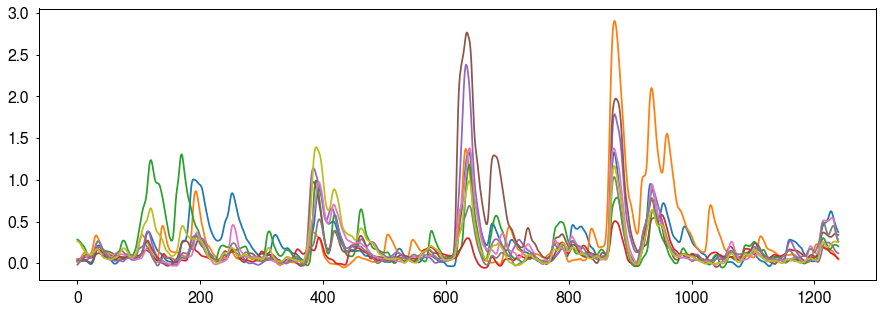

In [5]:
plt.figure(figsize=(15,5))
plt.plot(dFF0[30][:,1:10])
plt.show()

## Calculting information and correlation

In [6]:
def calc_info_measures(X,Y,hist_nbin,hist_range):
    """
    Return mutual information I_XY and variation of information V_XY
    X, Y: time arrays 
    hist_nbin: number of bins for histogram 
    hist_range: 2D matrix of histogram range
    """
    c_XY = np.histogram2d(X, Y, bins=hist_nbin, range=hist_range)[0]
    H_X = entropy(np.sum(c_XY,axis=0)/np.sum(c_XY)) 
    H_Y = entropy(np.sum(c_XY,axis=1)/np.sum(c_XY)) 
    H_XY = entropy(c_XY.flatten()/np.sum(c_XY))
    I_XY = H_X + H_Y - H_XY
    V_XY = H_XY - I_XY
    return I_XY, V_XY

def calc_parwise_info(X,hist_nbin,hist_range):
    """
    Return mutual information matrix I_X and variation of information matrix V_X
    X: [num_times x num_rois] dF/F0 
    hist_nbin: number of bins for histogram 
    hist_range: 2D matrix of histogram range 
    """
    n_rois = X.shape[1]
    I_X = np.zeros((n_rois,n_rois))
    V_X = np.zeros((n_rois,n_rois))
    for i in range(n_rois-1):
        for j in range(i,n_rois):
            I_X[i,j], V_X[i,j] = calc_info_measures(X[:,i],X[:,j],hist_nbin,hist_range)
            
            I_X[j,i] = I_X[i,j]
            V_X[j,i] = V_X[i,j]
        V_X[i,i] = 0 # in case of numerical issues 
    return I_X, V_X 

def calc_pairwise_corr(X):
    """
    Return correlation coefficient and distance matrices
    X: [num_times x num_rois] dF/F0 
    """
    corr_coef = np.corrcoef(X.T)
    corr_dist = np.sqrt(2*(1-corr_coef))
    return corr_coef, corr_dist


In [7]:
# select time window for calculation of measures 
t_range = [10, 12] # 2 sec after stim on 
hist_nbin = 50 # histogram number of bins for entropy calculation  

ind_range = (data_info['Fs'] * np.array(t_range)).astype(int) # converted index range of selected time window
# obtain range for histogram for entropy calculation 
dFF0_range = [np.min([np.min(x) for x in dFF0]), np.max([np.max(x) for x in dFF0])]
hist_range = np.array([dFF0_range,dFF0_range])

measures = dict(
    mutual_info = [],
    var_info = [],
    corr_coef = [], 
    corr_dist = [], 
)

t0 = time.time()

for dFF0_trial in dFF0:
    dff0 = dFF0_trial[ind_range[0]:ind_range[1],:]    
    I_X, V_X = calc_parwise_info(dff0,hist_nbin,hist_range)
    R_X, dR_X = calc_pairwise_corr(dff0)

    measures['mutual_info'].append(I_X)
    measures['var_info'].append(V_X)
    measures['corr_coef'].append(R_X)
    measures['corr_dist'].append(dR_X)

t1 = time.time()
print('Elapsed times = %.2f min' %((t1-t0)/60))

Elapsed times = 1.56 min


In [8]:
# Save files
data_file_pref = 'multisensory-measures-'
data_info['data_source'] += '\n' + preproc_file
data_info['selection'] = dict(
    time_window = t_range, 
    trial_list = select_trial_ids
)

data_info['measures_path'] = dict()

for k,v in measures.items():
    file_name = preproc_path + data_file_pref + k + '.npz'
    data_info['measures_path'][k] = file_name
    np.savez(file_name, X=v)
    
with open(preproc_path + data_file_pref + 'info.pkl','wb') as f:
    pickle.dump(dict(
        info=data_info,
        trial_ids=trial_ids
    ),f)

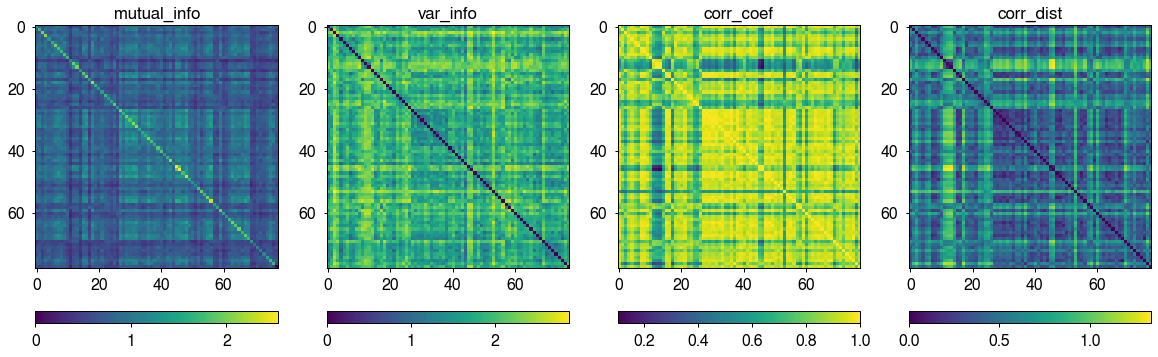

In [9]:
plt.figure(figsize=(20,10))
for i,(k,v) in enumerate(measures.items()):
    plt.subplot(1,4,i+1)
    im = plt.imshow(v[84])
    plt.title(k)
    plt.colorbar(im, fraction=0.04, pad=0.08, orientation='horizontal')
plt.show()